# Analisi finale

Si individuando 5 quadrati con dimensione 50*50 pixel attorno a delle minutiae (punti caratteristici) di interesse per entrambe le immagini. Le aree vengono individuate sulla prima immagine, con l'impronta di Canova, e successivamente mappate sulla seconda immagine sfruttando la sovrapposizione fornita dal committente, che viene assunta come valida.

Vengono successivamente effettuati diversi test a coppie per la differenza di medie nei valori dei pixel. Si lavora trasformando la sezione dell'immagine in un vettore, perdendo così la nozione spaziale, ma in questo modo si riesce a fornire una risposta al quesito originale che permette di sorpassare il problema della bassa qualità delle immagini.

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

## Impronte

In [2]:
img_path = '../data/cropped/processed/'
fig_path = './figures/'

images = [
    Image.open(img_path + 'mc.bmp').convert('L'),
    Image.open(img_path + 'sg.bmp').convert('L')
]

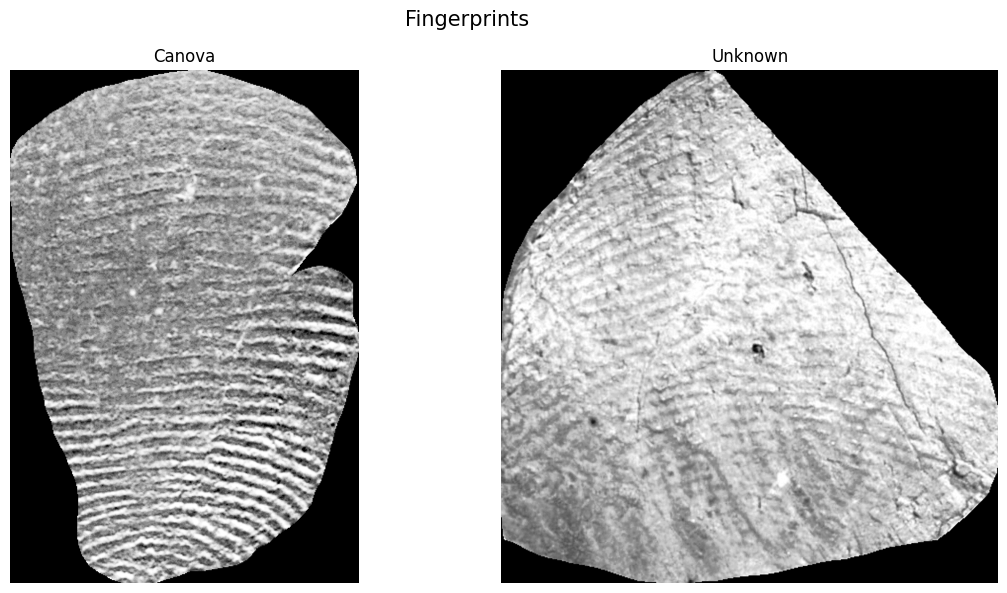

In [3]:
# plot 
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle('Fingerprints', fontsize = 15)

for ax, im, tit in zip(axs.flat, images, ['Canova', 'Unknown']):
    ax.imshow(im, cmap='Greys')
    ax.set_title(tit)
    ax.axis('off')

fig.tight_layout()
plt.savefig(fig_path + 'fingerprints.jpg')

## Aree di interesse

In [4]:
vertices = [ # y1 (topleft), y2, x1 (bottomright), x2 
    [420, 470, 500, 550],
    [400, 450, 100, 150],
    [100, 150, 400, 450],
    [200, 250, 200, 250]
]

ncrops = len(vertices)
crops = [[np.array(im)[v[0]:v[1], v[2]:v[3]] for v in vertices] for im in images]

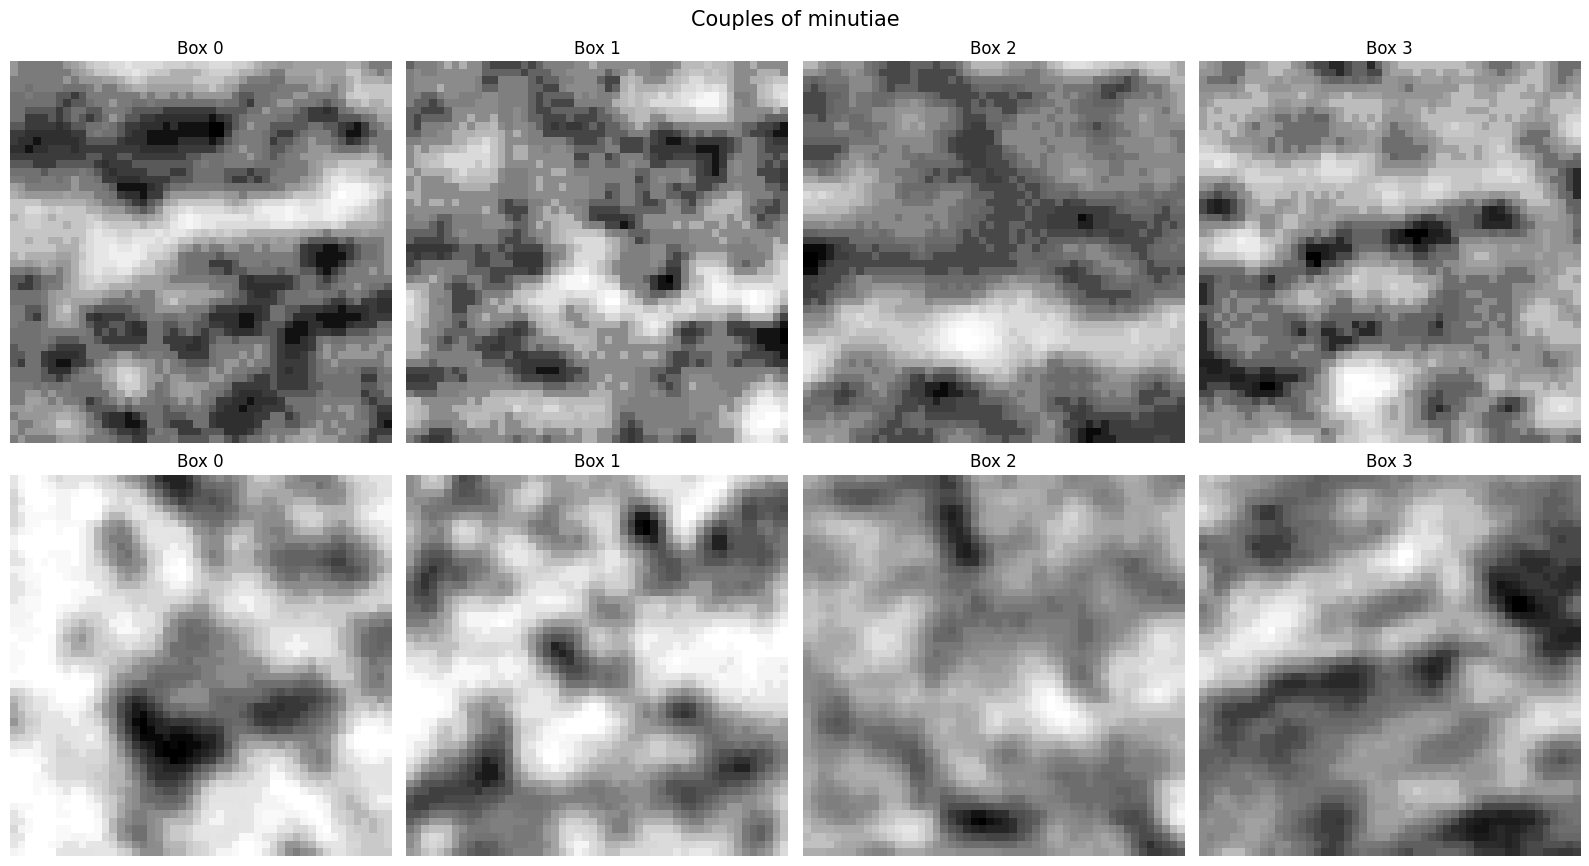

In [5]:
# plot boxes
fig, axs = plt.subplots(2, 4, figsize = (16, 9))
fig.suptitle('Couples of minutiae', fontsize = 15)

for i in range(len(crops)):
    for j in range(ncrops):
        im = crops[i][j]
        axs[i][j].imshow(im, cmap='Greys')
        axs[i][j].axis('off')
        axs[i][j].set_title(f'Box {j}')

fig.tight_layout()
plt.savefig(fig_path + 'paired_boxes.jpg')

## Test a due campioni 

In [6]:
print('Two-sample tests for every square')

# get reshaped arrays
samples_mc = [crop.reshape(-1)/255 for crop in crops[0]]
samples_sg = [crop.reshape(-1)/255 for crop in crops[1]]

# helper function
def print_results(res_dict):
    print('test\t\tstat\t\tp-value')
    print('-'*40)
    for k, v in res_dict.items():
        print(f'{k:10}\t{v[0]:.6f}\t{v[1]:.6f}') 


# test loop
results = []
for i in range(ncrops):

    # take the two samples
    x1 = samples_mc[i]
    x2 = samples_sg[i]

    # perform tests
    res = {}
    res['t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=True, alternative='two-sided')
    res['welch t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=False, alternative='two-sided')
    res['yuen t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=False, trim=0.15, alternative='two-sided')
    res['wilcoxon'] = sp.stats.wilcoxon(x1, x2, alternative='two-sided')
    res['kruskal'] = sp.stats.kruskal(x1, x2)
    results.append(res)

    # print results
    print(f'\nSquare {i+1}')
    print_results(res) 

Two-sample tests for every square

Square 1
test		stat		p-value
----------------------------------------
t-test    	108.664185	0.000000
welch t-test	108.664185	0.000000
yuen t-test	101.668711	0.000000
wilcoxon  	1568.500000	0.000000
kruskal   	3450.203749	0.000000

Square 2
test		stat		p-value
----------------------------------------
t-test    	105.346105	0.000000
welch t-test	105.346105	0.000000
yuen t-test	94.471832	0.000000
wilcoxon  	2480.500000	0.000000
kruskal   	3483.097565	0.000000

Square 3
test		stat		p-value
----------------------------------------
t-test    	16.381573	0.000000
welch t-test	16.381573	0.000000
yuen t-test	19.100827	0.000000
wilcoxon  	944612.500000	0.000000
kruskal   	325.270358	0.000000

Square 4
test		stat		p-value
----------------------------------------
t-test    	36.491975	0.000000
welch t-test	36.491975	0.000000
yuen t-test	32.843149	0.000000
wilcoxon  	412374.500000	0.000000
kruskal   	1004.557687	0.000000


In [7]:
print('Putting every square together...\n')

mc1 = np.stack(samples_mc).reshape(-1)
sg1 = np.stack(samples_sg).reshape(-1)

# perform tests
res = {}
res['t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=True, alternative='two-sided')
res['welch t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=False, alternative='two-sided')
res['yuen t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=False, trim=0.15, alternative='two-sided')
res['wilcoxon'] = sp.stats.wilcoxon(x1, x2, alternative='two-sided')
res['kruskal'] = sp.stats.kruskal(x1, x2)

# print results
print_results(res)

Putting every square together...

test		stat		p-value
----------------------------------------
t-test    	36.491975	0.000000
welch t-test	36.491975	0.000000
yuen t-test	32.843149	0.000000
wilcoxon  	412374.500000	0.000000
kruskal   	1004.557687	0.000000
